In [39]:
from tools import *
import os
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# Set up custom color palette
palette = ['#E0DFFC', '#5C2BD5', "#C5C4F7"]

def pretty_plots1(df, title='MOB-Suite Output Summary', save=False):
    
    # Create subplots: 2 rows, 2 columns for 4 plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Add some space between plots
    
    # Plot 1. Histogram of GC Content Distribution
    sns.histplot(df['gc'], bins=20, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('GC Content Distribution')
    axes[0, 0].set_xlabel('GC Content (%)')
    axes[0,0].set_xlim(0, 100)
    axes[0, 0].set_ylabel('Frequency')
    
    # Plot 2. Scatter Plot of Size vs GC Content
    sns.scatterplot(x='size', y='gc', data=df, hue='molecule_type', ax=axes[0, 1], sizes=(10, 10))
    axes[0, 1].set_title('Size vs GC Content')
    axes[0, 1].set_xlabel('Size (bp)')
    axes[0, 1].set_ylabel('GC Content (%)')
    axes[0, 1].set_xlim(0, 10000)
    axes[0, 1].legend(title='Molecule Type')
    
    
    # Plot 3. Bar Plot of Molecule Type Distribution
    sns.countplot(x='molecule_type', data=df, ax=axes[1, 0])
    axes[1, 0].set_title('Molecule Type Distribution')
    axes[1, 0].set_xlabel('Molecule Type')
    axes[1, 0].set_ylabel('Count')
    

    # Plot 4. Box Plot of Size Distribution
    sns.boxplot(x='size', data=df, ax=axes[1, 1])
    axes[1, 1].set_title('Size Distribution')
    axes[1, 1].set_xlabel('Size (bp)')
    axes[1, 1].set_ylabel('Distribution')
    
    # Set title for entire plot
    plt.suptitle(title, fontsize=25)
    
    # give it a tight layout
    plt.tight_layout()
    
    # give it a white background
    fig.patch.set_facecolor('white')
    plt.grid(color='black', linestyle='-', linewidth=0.5)
    if save:
        plt.savefig(title + '.png')
    # Show plot
    plt.show()

    

In [51]:
def sankey_plot1(contigs, dataset_name):
    # Initialize labels list with the initial categories
    labels = ["Original sequences", "Chromosome", "Putative Plasmids"]
    
    # Initialize source, target, and value lists
    source = []
    target = []
    value = []
    
    # Mapping of molecule types to corresponding node labels
    molecule_type_mapping = {
        'chromosome': "Chromosome",
        'plasmid': "Putative Plasmids"
    }
    # add original sequences as source with a flow to chromosome and putative plasmids 
    source.append(labels.index("Original sequences"))
    target.append(labels.index("Chromosome"))
    value.append(contigs[contigs["molecule_type"] == "chromosome"].shape[0])
    source.append(labels.index("Original sequences"))
    target.append(labels.index("Putative Plasmids"))
    value.append(contigs[contigs["molecule_type"] == "plasmid"].shape[0])
    
    # Count the occurrences of each molecule type and relaxase type combination
    for molecule_type, group in contigs.groupby('molecule_type'):
        # Add the chromosome or plasmid type as a label if not already present
        molecule_label = molecule_type_mapping.get(molecule_type, "Unknown")
        
        if molecule_label not in labels:
            labels.append(molecule_label)
            
        # Count flows to rep types
        rep_counts = group["rep_type(s)"].value_counts()
        for rep, count in rep_counts.items():
            if rep != '-':  # Ignore empty types
                if rep not in labels:
                    labels.append(rep)
                source.append(labels.index(molecule_label))
                target.append(labels.index(rep))
                value.append(count)
                
    # Create the Sankey diagram
    link_colours = ["#C5C4F7"] * 2 + ["#5C2BD5"] * (len(labels) - 3)
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=150,
            thickness=90,
            line=dict(color="black", width=2),
            label=labels,  # Labels for nodes
            color=[palette[0]] * 3 + [palette[1]] * (len(labels) - 3) # Color nodes by category
        ),
        link=dict(
            source=source,  # List of source node indices
            target=target,  # List of target node indices
            value=value, # Values associated with each flow
            color=link_colours 
        )
    )])
    # Adjust layout: background, title, and font
    fig.update_layout(
        title_text=f"Sankey Diagram of MOBsuite Results: Rep types for {dataset_name}",
        font=dict(size=18, color='black'),  # Set font color and size globally
        width=1800,  # Width of the plot
        height=1000,  # Height of the plot
        paper_bgcolor='white',  # White background outside the plot
        plot_bgcolor='white',  # White background inside the plot
        title_font_size=25,  # Title font size
        margin=dict(l=100, r=100, t=100, b=100)  # Set margins for a cleaner look
    )

    # Save the plot as a PNG file
    fig.write_image(f"mob_suite_sankey_{dataset_name}.png", scale=2)
    
    # Show the plot
    fig.show()
    fig.show()
            


In [78]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_plot(df):
    
    # Select the relevant numerical columns for PCA
    pca_columns = ['gc', 'size', 'mash_neighbor_distance' ]
    
    # turn relevant categorical columns into one-hot encoded columns
    one_hot = pd.get_dummies(df, columns=['rep_type(s)', 'relaxase_type(s)', 'mash_nearest_neighbor', ])
    new_df = pd.concat([df, one_hot], axis=1)

    # Scale the data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(new_df)
    
    # Perform PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(df_scaled)
    
    # Plot PCA
    plt.figure(figsize=(10, 7))
    novel_plasmids = df['sample_id'].str.contains('novel')
    plt.scatter(principal_components[:, 0], principal_components[:, 1], c=['red' if novel else 'blue' for novel in novel_plasmids], s=200)
    
    # Add labels
    for i, txt in enumerate(df['sample_id']):
        plt.annotate(txt, (principal_components[i, 0], principal_components[i, 1]), fontsize=12)
    
    plt.title('PCA of Genomic Properties (Novel Plasmids in Red)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()



sequences_feb
contig_report.txt


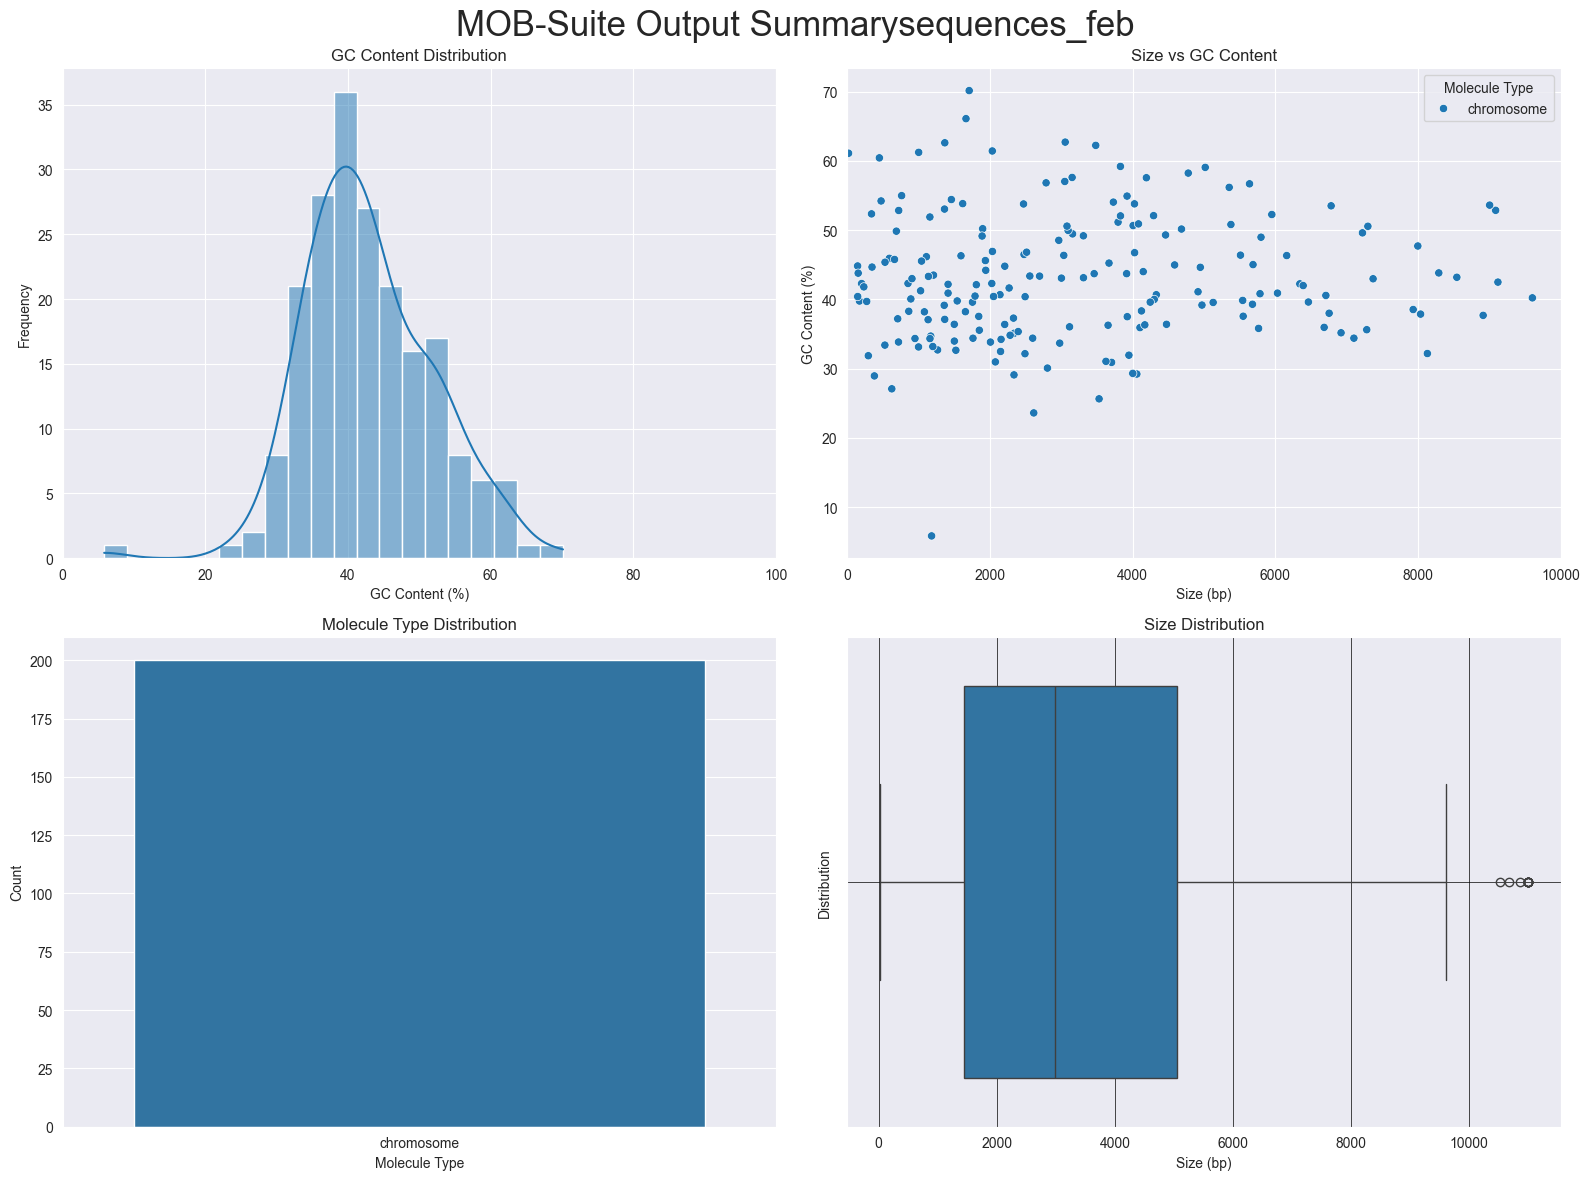

sequences_july
contig_report.txt


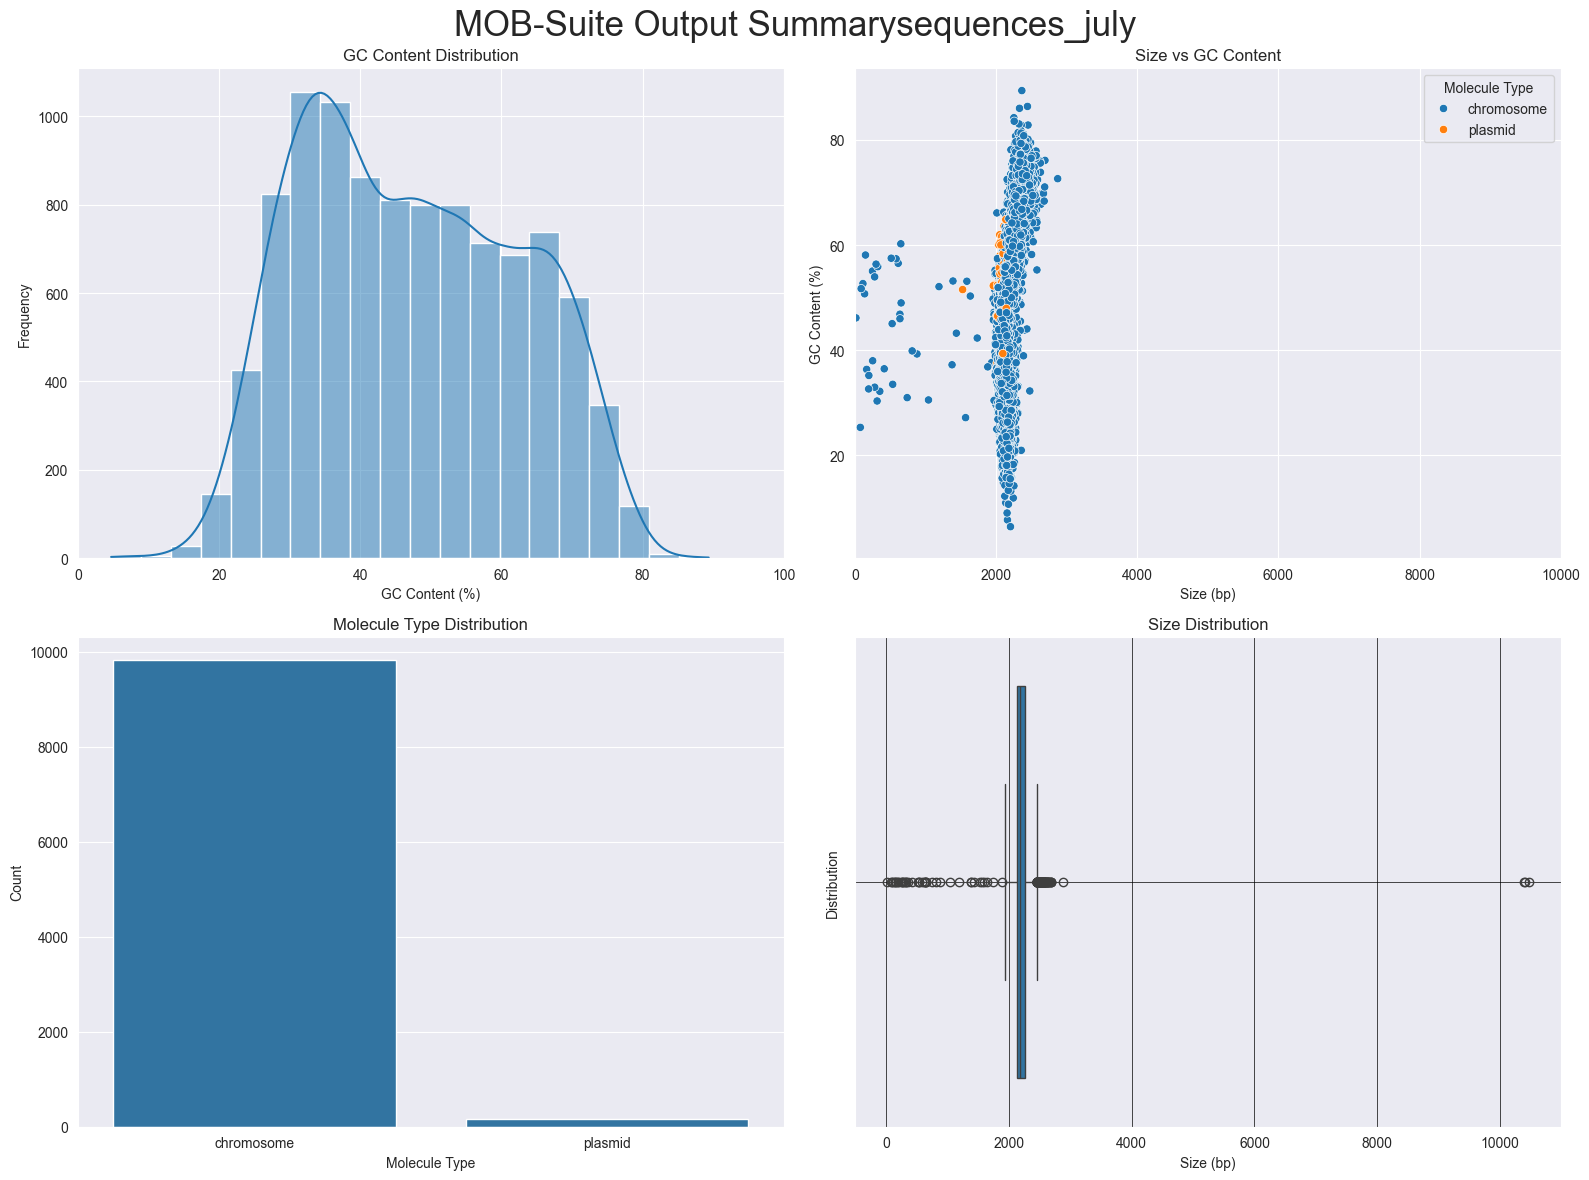

KeyError: "['sample_id' 'molecule_type' 'rep_type(s)' 'relaxase_type(s)'\n 'mash_nearest_neighbor'] not found in axis"

In [79]:
results_dir = 'mobsuite_outputs/'
for folder in [x for x in os.listdir(results_dir) if os.path.isdir(results_dir + x)]:
    print(folder)
    for file in os.listdir(results_dir + folder):
        if "contig" in file:
            print(file)
            df = pd.read_csv(results_dir + folder + '/' + file, sep='\t')
            pretty_plots1(df, title="MOB-Suite Output Summary" + folder, save=True)
            sankey_plot1(df, folder)
        elif "mobtyper" in file:
            df = pd.read_csv(results_dir + folder + '/' + file, sep='\t')
            pca_plot(df)
        
